dataset  
- amazon review
http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Books_5.json.gz

- chABSA
https://github.com/chakki-works/chABSA-dataset


https://github.com/ShopRunner/jupyter-notify
```
pip install jupyternotify
```

In [1]:
import tensorflow as tf
import numpy as np
import re
import os
import time
import datetime
from tensorflow.contrib.learn import preprocessing
import pickle
import pandas as pd
%matplotlib inline
%load_ext jupyternotify

/Users/tdual/anaconda2/envs/py3.6/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


<IPython.core.display.Javascript object>

In [2]:
class TextCNN:

    def __init__(
      self, sequence_length, num_classes, vocab_size, embedding_size, filter_sizes, num_filters, l2_reg_lambda=0.0):


        self.input_x = tf.placeholder(tf.int32, [None, sequence_length], name="input_x")
        self.input_y = tf.placeholder(tf.float32, [None, num_classes], name="input_y")
        self.dropout_keep_prob = tf.placeholder(tf.float32, name="dropout_keep_prob")

        l2_loss = tf.constant(0.0)


        with tf.device('/cpu:0'), tf.name_scope("embedding"):
            self.W = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0), name="W")
            self.embedded_chars = tf.nn.embedding_lookup(self.W, self.input_x)
            self.embedded_chars_expanded = tf.expand_dims(self.embedded_chars, -1)

 
        pooled_outputs = []
        for i, filter_size in enumerate(filter_sizes):
            with tf.name_scope("conv-maxpool-%s" % filter_size):
                filter_shape = [filter_size, embedding_size, 1, num_filters]
                W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name="W")
                b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name="b")
                conv = tf.nn.conv2d(self.embedded_chars_expanded,W,strides=[1, 1, 1, 1],padding="VALID", name="conv")
                h = tf.nn.relu(tf.nn.bias_add(conv, b), name="relu")
                pooled = tf.nn.max_pool(h, ksize=[1, sequence_length - filter_size + 1, 1, 1],strides=[1, 1, 1, 1],padding='VALID',name="pool")
                pooled_outputs.append(pooled)


        num_filters_total = num_filters * len(filter_sizes)
        print(num_filters_total)
        self.h_pool = tf.concat(pooled_outputs, 3)
        self.h_pool_flat = tf.reshape(self.h_pool, [-1, num_filters_total])
        

        with tf.name_scope("fc-1"):
            W = tf.Variable(tf.truncated_normal([num_filters_total, 1024], stddev=0.1), name="W")
            b = tf.Variable(tf.constant(0.1, shape=[1024]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            fc_1_output = tf.nn.relu(tf.nn.xw_plus_b(self.h_pool_flat, W, b), name="fc-1-out")


        with tf.name_scope("dropout-1"):
            drop_1 = tf.nn.dropout(fc_1_output, self.dropout_keep_prob)


        with tf.name_scope("fc-2"):
            W = tf.Variable(tf.truncated_normal([1024,1024], stddev=0.1), name="W")
            b = tf.Variable(tf.constant(0.1, shape=[1024]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            fc_2_output = tf.nn.relu(tf.nn.xw_plus_b(drop_1, W, b), name="fc-2-out")
            
        with tf.name_scope("dropout-2"):
            drop_2 = tf.nn.dropout(fc_2_output, self.dropout_keep_prob)


        with tf.name_scope("fc-3"):
            W = tf.Variable(tf.truncated_normal([1024, num_classes], stddev=0.1), name="W")
            b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name="b")
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            self.scores = tf.nn.xw_plus_b(drop_2, W, b, name="output")
            self.predictions = tf.argmax(self.scores, 1, name="predictions")
            
            
        with tf.name_scope("loss"):
            losses = tf.nn.softmax_cross_entropy_with_logits(logits=self.scores, labels=self.input_y)
            self.loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss


        with tf.name_scope("accuracy"):
            correct_predictions = tf.equal(self.predictions, tf.argmax(self.input_y, 1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, "float"), name="accuracy") 

In [4]:
#positive_data_file = "data/amazon/book_pos.txt"
#negative_data_file = "data/amazon/book_neg.txt"
positive_data_file = "data/chABSA/pos.txt"
negative_data_file = "data/chABSA/neg.txt"

In [5]:
def load_data_and_labels(positive_data_file, negative_data_file, level="char"):
       
    positive_examples = list(open(positive_data_file, "r").readlines())
    negative_examples = list(open(negative_data_file, "r").readlines())
    if level == "char":
        positive_examples = [s.replace(" ", "").replace("", " ").lower() for s in positive_examples]
        negative_examples = [s.replace(" ", "").replace("", " ").lower() for s in negative_examples]
    elif level == "word":
        positive_examples = [s.strip() for s in positive_examples]
        negative_examples = [s.strip() for s in negative_examples]
    else:
        print("invaid value of 'level'. ('char' or 'word') ")
        
    x_text = positive_examples + negative_examples

    positive_labels = [[0, 1] for _ in positive_examples]
    negative_labels = [[1, 0] for _ in negative_examples]
    y = np.concatenate([positive_labels, negative_labels], 0)
    
    return x_text, y

In [6]:
%%notify
x_text, y = load_data_and_labels(positive_data_file, negative_data_file)

<IPython.core.display.Javascript object>

In [7]:
len(x_text)

2830

In [8]:
x_text[0]

' 当 連 結 会 計 年 度 の 世 界 経 済 は 、 米 国 を 中 心 に 景 気 は 概 ね 堅 調 に 推 移 し ま し た が 、 英 国 の e u 離 脱 問 題 に よ る 影 響 の ほ か 、 中 国 を は じ め と す る 新 興 国 経 済 の 減 速 懸 念 や 米 国 新 政 権 の 政 策 動 向 の 不 確 実 性 な ど 、 景 気 の 先 行 き は 不 透 明 な 状 況 が 続 き ま し た \n '

In [9]:
length_list = np.array([len(r)for r in x_text])

In [10]:
df = pd.DataFrame(length_list, columns=["length"])
df.head()

,length
0,225
1,107
2,131
3,137
4,137


In [11]:
df.describe()

,length
count,2830.000000
mean,162.599293
std,77.631221
min,5.000000
25%,107.000000
50%,149.000000
75%,201.000000
max,805.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c214ab390>]],
      dtype=object)

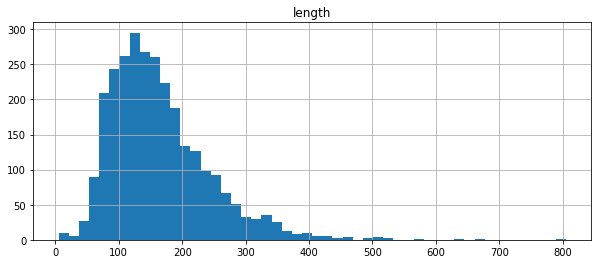

In [12]:
df.hist(bins=50,figsize=(10,4))

In [13]:
x_text = [x[:2000] if len(x) > 2000 else x for x in x_text]

In [14]:
length_list = np.array([len(r)for r in x_text])
df = pd.DataFrame(length_list, columns=["length"])
df.describe()

,length
count,2830.000000
mean,162.599293
std,77.631221
min,5.000000
25%,107.000000
50%,149.000000
75%,201.000000
max,805.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c214c0828>]],
      dtype=object)

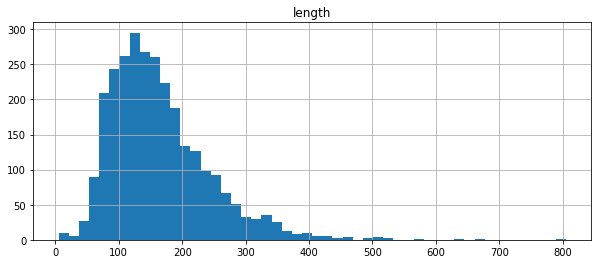

In [15]:
df.hist(bins=50,figsize=(10,4))

In [16]:
level = "char" #"word"

In [17]:
if level == "word":
    max_document_length = max([len(x.split(" ")) for x in x_text])
elif level == "char":
    max_document_length = max([len(x) for x in x_text])
print("max document length", max_document_length)

max document length 805


In [18]:
vocab_processor = preprocessing.VocabularyProcessor(max_document_length)

Instructions for updating:
Please use tensorflow/transform or tf.data.
Instructions for updating:
Please use tensorflow/transform or tf.data.


In [19]:
%%notify
x = np.array(list(vocab_processor.fit_transform(x_text)))

Instructions for updating:
Please use tensorflow/transform or tf.data.


<IPython.core.display.Javascript object>

In [20]:
test_percentage = 0.1#0.0010

In [21]:
%%notify
np.random.seed(10)
shuffle_indices = np.random.permutation(np.arange(len(y)))
x_shuffled = x[shuffle_indices]
y_shuffled = y[shuffle_indices]

test_sample_index = -1 * int(test_percentage * float(len(y)))
x_train, x_test = x_shuffled[:test_sample_index], x_shuffled[test_sample_index:]
y_train, y_test = y_shuffled[:test_sample_index], y_shuffled[test_sample_index:]

#del x, y, x_shuffled, y_shuffled

print("Vocabulary Size: {:d}".format(len(vocab_processor.vocabulary_)))
print("Train/Test split: {:d}/{:d}".format(len(y_train), len(y_test)))

Vocabulary Size: 1517
Train/Test split: 2547/283


<IPython.core.display.Javascript object>

In [22]:
print(x_train.shape)

(2547, 805)


In [23]:
def save_pickle():
    chunk_size =  int(len(x_train)/10)
    print(chunk_size)
    for i in range(0, len(x_train), chunck_size):
        print(i)
        end = i+chunck_size
        if end < len(x_train):
            chunk = x_train[i:  end]
        else:
            chunk = x_train[i:]
            end = len(x_train)
        with open("data/x_train_{}.pkl".format(end), "wb") as f:
            pickle.dump(chunk, f, protocol = 4)

In [24]:
def load_x_train():
    all_size = 999000
    chunk_size = 99900
    x_train =[]
    for i in range(0, all_size, chunck_size):
        print(i)
        end = i+chunk_size
        if end > len(reviews):
            end = all_size
        with open("data/x_train_{}.pkl".format(end), "rb") as f:
            x_train += pickle.load(f)
        return x_train
#x_train = load_x_train()

In [25]:
def batch_iter(data, batch_size, num_epochs, shuffle=True):
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int((len(data)-1)/batch_size) + 1
    for epoch in range(num_epochs):
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data
        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            yield shuffled_data[start_index:end_index]

In [26]:
sequence_length = x_train.shape[1]
num_classes = y_train.shape[1]
vocab_size = len(vocab_processor.vocabulary_)

In [27]:
embedding_size = 32     
filter_sizes = [2,3,4,5]    
num_filters=128               
dropout_keep_prob=0.5 
l2_reg_lambda=0.0       

In [28]:
TextCNN(sequence_length, num_classes, vocab_size, embedding_size, filter_sizes, num_filters, l2_reg_lambda)

512
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [29]:
timestamp = str(int(time.time()))
#timestamp = "1525609926"
prefix = ""
out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", timestamp, prefix))
print("Writing to {}\n".format(out_dir))

Writing to /Users/tdual/Workspace/char_level_cnn/runs/1526189751



In [30]:
batch_size=64                  
num_epochs=200            
evaluate_every=20         
num_checkpoints=5
learning_rate = 1e-3

allow_soft_placement=True    
log_device_placement=False  

save_checkpoint = True

In [31]:
with tf.Graph().as_default():
    session_conf = tf.ConfigProto(
      allow_soft_placement=allow_soft_placement,
      log_device_placement=log_device_placement)
    sess = tf.Session(config=session_conf)
    
    with sess.as_default():
        
        cnn = TextCNN(sequence_length, num_classes, vocab_size, embedding_size, filter_sizes, num_filters, l2_reg_lambda)


        global_step = tf.Variable(0, name="global_step", trainable=False)
        optimizer = tf.train.AdamOptimizer(learning_rate)
        grads_and_vars = optimizer.compute_gradients(cnn.loss)
        train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)


        grad_summaries = []
        for g, v in grads_and_vars:
            if g is not None:
                grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name), g)
                sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
                grad_summaries.append(grad_hist_summary)
                grad_summaries.append(sparsity_summary)
        grad_summaries_merged = tf.summary.merge(grad_summaries)


        loss_summary = tf.summary.scalar("loss", cnn.loss)
        acc_summary = tf.summary.scalar("accuracy", cnn.accuracy)

        train_summary_op = tf.summary.merge([loss_summary, acc_summary, grad_summaries_merged])
        
        train_summary_dir = os.path.join(out_dir, "summaries", "train")
        train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

        test_summary_op = tf.summary.merge([loss_summary, acc_summary])
        test_summary_dir = os.path.join(out_dir, "summaries", "test")
        test_summary_writer = tf.summary.FileWriter(test_summary_dir, sess.graph)

        if save_checkpoint:
            checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
            checkpoint_prefix = os.path.join(checkpoint_dir, "model")
            if not os.path.exists(checkpoint_dir):
                os.makedirs(checkpoint_dir)
            saver = tf.train.Saver(tf.global_variables(), max_to_keep=num_checkpoints)

  
        vocab_processor.save(os.path.join(out_dir, "vocab"))


        sess.run(tf.global_variables_initializer())

        def train_step(x_batch, y_batch):
            feed_dict = {
              cnn.input_x: x_batch,
              cnn.input_y: y_batch,
              cnn.dropout_keep_prob: dropout_keep_prob
            }
            _, step, summaries, loss, accuracy = sess.run([train_op, global_step, train_summary_op, cnn.loss, cnn.accuracy], feed_dict)
            
            time_str = datetime.datetime.now().isoformat()
            print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
            train_summary_writer.add_summary(summaries, step)

        def test_step(x_batch, y_batch, writer=None):
            feed_dict = {
              cnn.input_x: x_batch,
              cnn.input_y: y_batch,
              cnn.dropout_keep_prob: 1.0
            }
            step, summaries, loss, accuracy = sess.run([global_step, test_summary_op, cnn.loss, cnn.accuracy], feed_dict)
            time_str = datetime.datetime.now().isoformat()
            print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
            if writer:
                writer.add_summary(summaries, step)

        batches = batch_iter(list(zip(x_train, y_train)), batch_size, num_epochs)
        for batch in batches:
            x_batch, y_batch = zip(*batch)
            train_step(x_batch, y_batch)
            current_step = tf.train.global_step(sess, global_step)
            
            if current_step % evaluate_every == 0:
                print("\nEvaluation:")
                test_step(x_test, y_test, writer=test_summary_writer)
                print("")
                
            if save_checkpoint and current_step % evaluate_every == 0:
                path = saver.save(sess, checkpoint_prefix, global_step=current_step)
                print("Saved model checkpoint to {}\n".format(path))

512
INFO:tensorflow:Summary name embedding/W:0/grad/hist is illegal; using embedding/W_0/grad/hist instead.
INFO:tensorflow:Summary name embedding/W:0/grad/sparsity is illegal; using embedding/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-2/W:0/grad/hist is illegal; using conv-maxpool-2/W_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-2/W:0/grad/sparsity is illegal; using conv-maxpool-2/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-2/b:0/grad/hist is illegal; using conv-maxpool-2/b_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-2/b:0/grad/sparsity is illegal; using conv-maxpool-2/b_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/W:0/grad/hist is illegal; using conv-maxpool-3/W_0/grad/hist instead.
INFO:tensorflow:Summary name conv-maxpool-3/W:0/grad/sparsity is illegal; using conv-maxpool-3/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name conv-maxpool-3/b:0/grad/hist is illegal; us

2018-05-13T14:36:30.688621: step 72, loss 1.56013, acc 0.46875
2018-05-13T14:36:31.262610: step 73, loss 1.40701, acc 0.578125
2018-05-13T14:36:31.769976: step 74, loss 1.40695, acc 0.59375
2018-05-13T14:36:32.294869: step 75, loss 1.27674, acc 0.546875
2018-05-13T14:36:32.828070: step 76, loss 1.73711, acc 0.484375
2018-05-13T14:36:33.329704: step 77, loss 1.59753, acc 0.484375
2018-05-13T14:36:33.819303: step 78, loss 0.81099, acc 0.6875
2018-05-13T14:36:34.295513: step 79, loss 1.02549, acc 0.609375
2018-05-13T14:36:34.754910: step 80, loss 1.01229, acc 0.647059

Evaluation:
2018-05-13T14:36:35.342546: step 80, loss 0.643042, acc 0.625442

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/1526189751/checkpoints/model-80

2018-05-13T14:36:36.022534: step 81, loss 1.09611, acc 0.53125
2018-05-13T14:36:36.530257: step 82, loss 0.883207, acc 0.578125
2018-05-13T14:36:36.990646: step 83, loss 1.11955, acc 0.59375
2018-05-13T14:36:37.483777: step 84, loss 1.04013, acc 0

2018-05-13T14:37:28.878146: step 182, loss 0.46464, acc 0.734375
2018-05-13T14:37:29.350841: step 183, loss 0.435622, acc 0.78125
2018-05-13T14:37:29.849270: step 184, loss 0.544593, acc 0.734375
2018-05-13T14:37:30.356004: step 185, loss 0.412175, acc 0.875
2018-05-13T14:37:30.874637: step 186, loss 0.52001, acc 0.765625
2018-05-13T14:37:31.453548: step 187, loss 0.440029, acc 0.78125
2018-05-13T14:37:31.974443: step 188, loss 0.612741, acc 0.671875
2018-05-13T14:37:32.485961: step 189, loss 0.448835, acc 0.828125
2018-05-13T14:37:32.979084: step 190, loss 0.488954, acc 0.78125
2018-05-13T14:37:33.471455: step 191, loss 0.348694, acc 0.875
2018-05-13T14:37:33.949905: step 192, loss 0.433376, acc 0.75
2018-05-13T14:37:34.491770: step 193, loss 0.424301, acc 0.71875
2018-05-13T14:37:34.989321: step 194, loss 0.398889, acc 0.765625
2018-05-13T14:37:35.503076: step 195, loss 0.509166, acc 0.75
2018-05-13T14:37:35.984568: step 196, loss 0.433085, acc 0.828125
2018-05-13T14:37:36.478586: st

2018-05-13T14:38:26.582099: step 294, loss 0.474366, acc 0.78125
2018-05-13T14:38:27.068995: step 295, loss 0.275262, acc 0.859375
2018-05-13T14:38:27.596253: step 296, loss 0.510578, acc 0.71875
2018-05-13T14:38:28.139105: step 297, loss 0.564638, acc 0.75
2018-05-13T14:38:28.645400: step 298, loss 0.461016, acc 0.828125
2018-05-13T14:38:29.139843: step 299, loss 0.397684, acc 0.765625
2018-05-13T14:38:29.653121: step 300, loss 0.36219, acc 0.828125

Evaluation:
2018-05-13T14:38:30.165923: step 300, loss 0.374223, acc 0.844523

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/1526189751/checkpoints/model-300

2018-05-13T14:38:30.854395: step 301, loss 0.504356, acc 0.796875
2018-05-13T14:38:31.398179: step 302, loss 0.355497, acc 0.84375
2018-05-13T14:38:31.909474: step 303, loss 0.435989, acc 0.8125
2018-05-13T14:38:32.395707: step 304, loss 0.467738, acc 0.8125
2018-05-13T14:38:32.797077: step 305, loss 0.464972, acc 0.75
2018-05-13T14:38:33.195779: step 306, los

2018-05-13T14:39:24.408362: step 404, loss 0.36273, acc 0.8125
2018-05-13T14:39:24.863011: step 405, loss 0.292089, acc 0.875
2018-05-13T14:39:25.358653: step 406, loss 0.370709, acc 0.8125
2018-05-13T14:39:25.823076: step 407, loss 0.317014, acc 0.859375
2018-05-13T14:39:26.284677: step 408, loss 0.318071, acc 0.8125
2018-05-13T14:39:26.728436: step 409, loss 0.294767, acc 0.890625
2018-05-13T14:39:27.203946: step 410, loss 0.292449, acc 0.90625
2018-05-13T14:39:27.693077: step 411, loss 0.289691, acc 0.84375
2018-05-13T14:39:28.172692: step 412, loss 0.327099, acc 0.859375
2018-05-13T14:39:28.692822: step 413, loss 0.315276, acc 0.84375
2018-05-13T14:39:29.157891: step 414, loss 0.328864, acc 0.8125
2018-05-13T14:39:29.622997: step 415, loss 0.24836, acc 0.875
2018-05-13T14:39:30.138843: step 416, loss 0.40739, acc 0.8125
2018-05-13T14:39:30.658192: step 417, loss 0.304224, acc 0.859375
2018-05-13T14:39:31.115094: step 418, loss 0.35638, acc 0.84375
2018-05-13T14:39:31.584268: step 4

2018-05-13T14:40:20.527402: step 517, loss 0.374907, acc 0.8125
2018-05-13T14:40:20.991691: step 518, loss 0.313222, acc 0.8125
2018-05-13T14:40:21.472461: step 519, loss 0.2746, acc 0.84375
2018-05-13T14:40:21.883723: step 520, loss 0.371535, acc 0.823529

Evaluation:
2018-05-13T14:40:22.488881: step 520, loss 0.312041, acc 0.869258

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/1526189751/checkpoints/model-520

2018-05-13T14:40:23.172543: step 521, loss 0.416153, acc 0.765625
2018-05-13T14:40:23.635725: step 522, loss 0.379172, acc 0.765625
2018-05-13T14:40:24.085774: step 523, loss 0.265552, acc 0.875
2018-05-13T14:40:24.558524: step 524, loss 0.265252, acc 0.828125
2018-05-13T14:40:24.998562: step 525, loss 0.209662, acc 0.9375
2018-05-13T14:40:25.482231: step 526, loss 0.221084, acc 0.90625
2018-05-13T14:40:25.924843: step 527, loss 0.223581, acc 0.90625
2018-05-13T14:40:26.358259: step 528, loss 0.338293, acc 0.859375
2018-05-13T14:40:26.789412: step 529, l

2018-05-13T14:41:15.592970: step 627, loss 0.311958, acc 0.84375
2018-05-13T14:41:16.055951: step 628, loss 0.32339, acc 0.796875
2018-05-13T14:41:16.583145: step 629, loss 0.26613, acc 0.8125
2018-05-13T14:41:17.053263: step 630, loss 0.171224, acc 0.90625
2018-05-13T14:41:17.542334: step 631, loss 0.212193, acc 0.875
2018-05-13T14:41:18.023224: step 632, loss 0.192296, acc 0.890625
2018-05-13T14:41:18.559340: step 633, loss 0.220793, acc 0.890625
2018-05-13T14:41:19.061264: step 634, loss 0.135754, acc 0.921875
2018-05-13T14:41:19.529098: step 635, loss 0.189443, acc 0.90625
2018-05-13T14:41:20.011966: step 636, loss 0.236609, acc 0.890625
2018-05-13T14:41:20.502499: step 637, loss 0.15001, acc 0.9375
2018-05-13T14:41:20.992986: step 638, loss 0.154154, acc 0.96875
2018-05-13T14:41:21.493328: step 639, loss 0.236054, acc 0.921875
2018-05-13T14:41:21.886152: step 640, loss 0.235648, acc 0.843137

Evaluation:
2018-05-13T14:41:22.424368: step 640, loss 0.317614, acc 0.879859

Saved mode

2018-05-13T14:42:11.555539: step 739, loss 0.224274, acc 0.90625
2018-05-13T14:42:12.052192: step 740, loss 0.245608, acc 0.890625

Evaluation:
2018-05-13T14:42:12.605166: step 740, loss 0.307933, acc 0.893993

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/1526189751/checkpoints/model-740

2018-05-13T14:42:13.392773: step 741, loss 0.336313, acc 0.828125
2018-05-13T14:42:13.885143: step 742, loss 0.191889, acc 0.875
2018-05-13T14:42:14.369400: step 743, loss 0.154323, acc 0.890625
2018-05-13T14:42:14.868175: step 744, loss 0.162895, acc 0.953125
2018-05-13T14:42:15.332989: step 745, loss 0.187496, acc 0.890625
2018-05-13T14:42:15.769656: step 746, loss 0.157943, acc 0.90625
2018-05-13T14:42:16.232530: step 747, loss 0.303488, acc 0.828125
2018-05-13T14:42:16.755959: step 748, loss 0.197255, acc 0.921875
2018-05-13T14:42:17.233733: step 749, loss 0.164194, acc 0.90625
2018-05-13T14:42:17.760196: step 750, loss 0.23409, acc 0.90625
2018-05-13T14:42:18.338083: step 

2018-05-13T14:43:06.113456: step 848, loss 0.180961, acc 0.890625
2018-05-13T14:43:06.550692: step 849, loss 0.183633, acc 0.890625
2018-05-13T14:43:07.006925: step 850, loss 0.282317, acc 0.8125
2018-05-13T14:43:07.471636: step 851, loss 0.180235, acc 0.859375
2018-05-13T14:43:07.943211: step 852, loss 0.153836, acc 0.90625
2018-05-13T14:43:08.414656: step 853, loss 0.18147, acc 0.90625
2018-05-13T14:43:08.926880: step 854, loss 0.217485, acc 0.875
2018-05-13T14:43:09.324566: step 855, loss 0.22393, acc 0.875
2018-05-13T14:43:09.725260: step 856, loss 0.140823, acc 0.921875
2018-05-13T14:43:10.130895: step 857, loss 0.195893, acc 0.875
2018-05-13T14:43:10.516360: step 858, loss 0.251745, acc 0.859375
2018-05-13T14:43:10.896553: step 859, loss 0.124446, acc 0.890625
2018-05-13T14:43:11.280065: step 860, loss 0.136192, acc 0.984375

Evaluation:
2018-05-13T14:43:11.752714: step 860, loss 0.285733, acc 0.886926

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/15261897

2018-05-13T14:44:00.555045: step 960, loss 0.176656, acc 0.882353

Evaluation:
2018-05-13T14:44:01.077589: step 960, loss 0.366352, acc 0.897527

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/1526189751/checkpoints/model-960

2018-05-13T14:44:01.745113: step 961, loss 0.255164, acc 0.828125
2018-05-13T14:44:02.290720: step 962, loss 0.145692, acc 0.890625
2018-05-13T14:44:02.833147: step 963, loss 0.150111, acc 0.921875
2018-05-13T14:44:03.277867: step 964, loss 0.231816, acc 0.890625
2018-05-13T14:44:03.800739: step 965, loss 0.0856069, acc 0.96875
2018-05-13T14:44:04.314656: step 966, loss 0.178476, acc 0.890625
2018-05-13T14:44:04.690720: step 967, loss 0.162248, acc 0.921875
2018-05-13T14:44:05.054338: step 968, loss 0.17525, acc 0.921875
2018-05-13T14:44:05.429853: step 969, loss 0.121438, acc 0.921875
2018-05-13T14:44:05.822917: step 970, loss 0.313759, acc 0.828125
2018-05-13T14:44:06.189009: step 971, loss 0.225047, acc 0.875
2018-05-13T14:44:06.684786: s

2018-05-13T14:44:56.223828: step 1068, loss 0.142588, acc 0.90625
2018-05-13T14:44:56.727609: step 1069, loss 0.169849, acc 0.890625
2018-05-13T14:44:57.248870: step 1070, loss 0.116933, acc 0.921875
2018-05-13T14:44:57.750267: step 1071, loss 0.145303, acc 0.9375
2018-05-13T14:44:58.196572: step 1072, loss 0.131546, acc 0.921875
2018-05-13T14:44:58.656732: step 1073, loss 0.143882, acc 0.921875
2018-05-13T14:44:59.125574: step 1074, loss 0.0998347, acc 0.953125
2018-05-13T14:44:59.648027: step 1075, loss 0.110497, acc 0.9375
2018-05-13T14:45:00.118077: step 1076, loss 0.119553, acc 0.953125
2018-05-13T14:45:00.657617: step 1077, loss 0.100394, acc 0.953125
2018-05-13T14:45:01.143438: step 1078, loss 0.212864, acc 0.90625
2018-05-13T14:45:01.646308: step 1079, loss 0.114517, acc 0.953125
2018-05-13T14:45:02.088182: step 1080, loss 0.0827507, acc 0.980392

Evaluation:
2018-05-13T14:45:02.564639: step 1080, loss 0.314242, acc 0.904594

Saved model checkpoint to /Users/tdual/Workspace/cha

2018-05-13T14:45:53.236058: step 1178, loss 0.251063, acc 0.875
2018-05-13T14:45:53.782071: step 1179, loss 0.180057, acc 0.921875
2018-05-13T14:45:54.253319: step 1180, loss 0.0576113, acc 0.96875

Evaluation:
2018-05-13T14:45:54.746242: step 1180, loss 0.463618, acc 0.908127

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/1526189751/checkpoints/model-1180

2018-05-13T14:45:55.303298: step 1181, loss 0.101473, acc 0.96875
2018-05-13T14:45:55.726199: step 1182, loss 0.206428, acc 0.875
2018-05-13T14:45:56.093234: step 1183, loss 0.114116, acc 0.921875
2018-05-13T14:45:56.484271: step 1184, loss 0.106253, acc 0.921875
2018-05-13T14:45:56.970780: step 1185, loss 0.0842574, acc 0.953125
2018-05-13T14:45:57.449117: step 1186, loss 0.134437, acc 0.921875
2018-05-13T14:45:57.988028: step 1187, loss 0.0362582, acc 1
2018-05-13T14:45:58.496871: step 1188, loss 0.0663823, acc 0.96875
2018-05-13T14:45:58.954870: step 1189, loss 0.0917455, acc 0.9375
2018-05-13T14:45:59.4916

2018-05-13T14:46:44.971404: step 1285, loss 0.0843288, acc 0.9375
2018-05-13T14:46:45.531993: step 1286, loss 0.1307, acc 0.9375
2018-05-13T14:46:46.060790: step 1287, loss 0.150009, acc 0.90625
2018-05-13T14:46:46.557820: step 1288, loss 0.0733695, acc 0.953125
2018-05-13T14:46:47.078643: step 1289, loss 0.0785428, acc 0.953125
2018-05-13T14:46:47.654389: step 1290, loss 0.0301259, acc 1
2018-05-13T14:46:48.162497: step 1291, loss 0.148048, acc 0.921875
2018-05-13T14:46:48.629398: step 1292, loss 0.0730828, acc 0.96875
2018-05-13T14:46:49.128976: step 1293, loss 0.0615704, acc 0.96875
2018-05-13T14:46:49.630977: step 1294, loss 0.0669009, acc 0.96875
2018-05-13T14:46:50.091007: step 1295, loss 0.106032, acc 0.9375
2018-05-13T14:46:50.575376: step 1296, loss 0.0914895, acc 0.96875
2018-05-13T14:46:51.027922: step 1297, loss 0.0991688, acc 0.9375
2018-05-13T14:46:51.508320: step 1298, loss 0.120176, acc 0.890625
2018-05-13T14:46:51.993396: step 1299, loss 0.106482, acc 0.9375
2018-05-13

2018-05-13T14:47:39.151808: step 1395, loss 0.0764228, acc 0.953125
2018-05-13T14:47:39.594964: step 1396, loss 0.130351, acc 0.9375
2018-05-13T14:47:40.013529: step 1397, loss 0.11788, acc 0.9375
2018-05-13T14:47:40.469359: step 1398, loss 0.100747, acc 0.953125
2018-05-13T14:47:40.923406: step 1399, loss 0.103009, acc 0.9375
2018-05-13T14:47:41.262447: step 1400, loss 0.0936434, acc 0.980392

Evaluation:
2018-05-13T14:47:41.703406: step 1400, loss 0.412043, acc 0.908127

Saved model checkpoint to /Users/tdual/Workspace/char_level_cnn/runs/1526189751/checkpoints/model-1400

2018-05-13T14:47:42.339456: step 1401, loss 0.0750653, acc 0.984375
2018-05-13T14:47:42.708025: step 1402, loss 0.111989, acc 0.96875
2018-05-13T14:47:43.128895: step 1403, loss 0.116811, acc 0.9375
2018-05-13T14:47:43.564387: step 1404, loss 0.102807, acc 0.96875
2018-05-13T14:47:43.982165: step 1405, loss 0.0877224, acc 0.96875
2018-05-13T14:47:44.412359: step 1406, loss 0.0587618, acc 0.984375
2018-05-13T14:47:4

2018-05-13T14:48:31.769529: step 1502, loss 0.0583356, acc 1
2018-05-13T14:48:32.300122: step 1503, loss 0.137525, acc 0.9375
2018-05-13T14:48:32.888418: step 1504, loss 0.0781788, acc 0.96875
2018-05-13T14:48:33.399236: step 1505, loss 0.0743335, acc 0.96875
2018-05-13T14:48:33.875344: step 1506, loss 0.141491, acc 0.921875
2018-05-13T14:48:34.350128: step 1507, loss 0.101222, acc 0.9375
2018-05-13T14:48:34.829808: step 1508, loss 0.154046, acc 0.90625
2018-05-13T14:48:35.217507: step 1509, loss 0.141141, acc 0.921875
2018-05-13T14:48:35.657919: step 1510, loss 0.151503, acc 0.921875
2018-05-13T14:48:36.139372: step 1511, loss 0.0719045, acc 0.96875
2018-05-13T14:48:36.612692: step 1512, loss 0.0934121, acc 0.9375
2018-05-13T14:48:37.144740: step 1513, loss 0.110206, acc 0.9375
2018-05-13T14:48:37.611728: step 1514, loss 0.0844808, acc 0.96875
2018-05-13T14:48:38.038354: step 1515, loss 0.156693, acc 0.921875
2018-05-13T14:48:38.555024: step 1516, loss 0.0578747, acc 0.984375
2018-05-

KeyboardInterrupt: 

char level cnn 
- 1525408577  
- 1526189751   good

In [ ]:
tf.train.get_checkpoint_state('./runs/1526189751/checkpoints')

In [ ]:
def get_feature(x):
    with tf.Graph().as_default():
        session_conf = tf.ConfigProto(
          allow_soft_placement=allow_soft_placement,
          log_device_placement=log_device_placement)
        sess = tf.Session(config=session_conf)
        with sess.as_default():
            cnn = TextCNN(
                sequence_length=x_train.shape[1],
                num_classes=y_train.shape[1],
                vocab_size=len(vocab_processor.vocabulary_),
                embedding_size=embedding_dim,
                filter_sizes=list(map(int, filter_sizes.split(","))),
                num_filters=num_filters,
                l2_reg_lambda=l2_reg_lambda)

            saver = tf.train.Saver()
            sess.run(tf.global_variables_initializer())

            saver.restore(sess, "runs/1525408577/checkpoints/model-98400")

            feed_dict = {
                  cnn.input_x: x,
                  cnn.dropout_keep_prob: 1.0
                }
            feature_5, feature_2 = sess.run([cnn.f_h, cnn.scores ], feed_dict=feed_dict)
    return feature_5, feature_2


In [ ]:
review = list(open("data/amazon/rating_5.txt", "r").readlines())
review = [s.strip() for s in review]

In [ ]:
y = []
x = []
for r in review:
    l = r.split(":::::")
    y.append(float(l[0]))
    x.append(l[1].replace(" ", "").replace("", " "))

In [ ]:
vocab_processor = preprocessing.VocabularyProcessor.restore(os.path.join("runs/1525408577", "vocab"))

In [ ]:
x[0]

In [ ]:
y[0]

In [ ]:
x = np.array(list(vocab_processor.fit_transform(x)))
y = np.array(y)

In [ ]:
len(x)

In [ ]:
feature_5 ,feature_2 = get_feature(x[:100])

In [ ]:
feature_5[0]

In [ ]:
feature_5[1]

In [ ]:
s = 0
chunk_size = 100
for i in range(0, len(x) , chunk_size):
    feature_5 ,feature_2 = get_feature(x[i:i+chunk_size])
    for f, r in zip(feature_5, y[i:i+chunk_size]):
        s  += int(np.argmax(f) == r)
    print(s/(i+chunk_size))
s

In [ ]:
np.argmax(feature_5)

In [ ]:
feature_2 [0]  #[neg, pos]